In [18]:
# All imports

#import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio
import pandas as pd
import numpy as np

from skimage.feature import hessian_matrix_det
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from sklearn.model_selection import train_test_split


ha


In [19]:
# Load the MPII dataset
## TODO Take into main notebook

mat = sio.loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat', struct_as_record=False)

In [20]:
# TODO Take into main notebook
rel = mat['RELEASE']

obj_rel = rel[0,0]

annolist = obj_rel.__dict__['annolist']
img_tra = obj_rel.__dict__['img_train']
act = obj_rel.__dict__['act']

n = annolist.shape[1]

In [21]:
# TODO Take into main notebook
# All the columns of the data 

data_arr = ['NAME','r ankle_X','r ankle_Y', 'r knee_X','r knee_Y', 'r hip_X','r hip_Y', 'l hip_X','l hip_Y', 'l knee_X','l knee_Y', 'l ankle_X','l ankle_Y','pelvis_X','pelvis_Y','thorax_X','thorax_Y','upper neck_X','upper neck_Y', 'head top_X','head top_Y', 'r wrist_X','r wrist_Y','r elbow_X','r elbow_Y', 'r shoulder_X','r shoulder_Y','l shoulder_X','l shoulder_Y','l elbow_X','l elbow_Y', 'l wrist_X','l wrist_Y','Scale','Activity','Category']

data = pd.DataFrame(columns=data_arr)

In [22]:
# This dataset is in .mat format.
# 
# Convert the data into dataframe

for ix in range(0,annolist.shape[1]):
    if img_tra[0,ix] == 0:
        continue
    temp_arr = []
    obj_list = annolist[0,ix]
    obj_act = act[ix,0]
    
    rect =obj_list.__dict__['annorect']
    img_d = obj_list.__dict__['image']
    if rect.shape[0] ==0:
        continue
        
    obj_rect = rect[0,0]
    obj_img = img_d[0,0]
    
    
    if 'annopoints' not in obj_rect._fieldnames:
        continue
    
    name_d = obj_img.__dict__['name']
    name = name_d[0]
    temp_arr.append(name)
    annopoints = obj_rect.__dict__['annopoints']
    if annopoints.shape[0]==0:
        continue
    obj_points = annopoints[0,0]
    points = obj_points.__dict__['point']
    cnt = 0
    px = 0
    
    for n in range(0,32):
        temp_arr.append(-1)
    
    
    for px in range(0,points.shape[1]):
        po = points[0,px]
        po_id = po.__dict__['id']
        
        po_x = po.__dict__['x']
        po_y = po.__dict__['y']
        po_isvisible = po.__dict__['is_visible']
        ind = 2*po_id[0][0]+1
        temp_arr[ind] = po_x[0][0]
        temp_arr[ind+1] = po_y[0][0]
        
        
    scale = obj_rect.__dict__['scale']
    temp_arr.append(scale[0][0])
    
    activity = act[ix,0]
    
    a_n = activity.act_name
    c_n = activity.cat_name
    
    if a_n.shape[0]==0:
        temp_arr.append(a_n)
    else:
        temp_arr.append(activity.act_name[0])
    if c_n.shape[0]==0:
        temp_arr.append(c_n)
    else:
        temp_arr.append(activity.cat_name[0])
    
    temp_data_f = pd.DataFrame([temp_arr],columns=data_arr)
    
    data = pd.concat([data,temp_data_f])

data.to_csv('mpii_dataset.csv')

In [28]:
data.tail(10)

In [154]:
# Get data from 2 classes. Clean the data
# 
# Classes  : Running , Bicycling 
def Clean_data(filter_data, data_arr):
    input_running = filter_data[filter_data["Activity"] == "running"]
    input_cycling= filter_data[filter_data["Activity"] == "bicycling, mountain"]

    input_cycling_filtered =  input_cycling[input_cycling[data_arr] != -1]
    
    input_running_filtered =  input_running[input_running[data_arr] != -1]

    return input_running_filtered, input_cycling_filtered

In [252]:
# Extract keypoints and display the image
from PIL import Image
def imag(df, ix):
    img = df['NAME'][ix]
    print(img)
    
    im = Image.open('../MPII/'+img )
    print(im.size)
    implot = plt.imshow(im)
    px=2
    
    while px <34:
        col = df.columns[px]
        x = df[col][ix]
        col = df.columns[px+1]
        y = df[col][ix]
        #print(col,x,y)
        plt.scatter([[x]],[[y]])
        plt.savefig("running.jpg")
        px=px+2

In [158]:
# TODO Take into main notebook
df_obj = pd.read_csv('mpii_dataset.csv')
input_running_filtered, input_cycling_filtered = Clean_data(df_obj,data_arr)

032694102.jpg
(1280, 720)


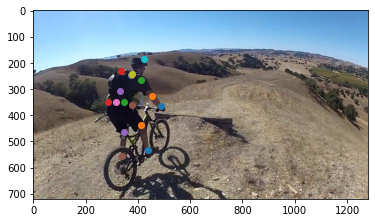

In [262]:
# "image_id" is used to index an image from the dataframe
image_id = 15
imag(input_cycling_filtered,input_cycling_filtered.index[image_id])

In [188]:
# Preprocess the data
import geomstats.backend as gs
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
from geomstats.learning.pca import TangentPCA

def format_dataframe(df, label):
    feature_names=df.columns

    samples=[]
    for sample in range(len(df)):
        
        sample_features=[]
        
        for index in range(len(feature_names)-1):
            
            if feature_names[index][:-1]==feature_names[index+1][:-1]:
                
                landmark_coord=[df.iloc[sample][feature_names[index]],df.iloc[sample][feature_names[index+1]]]
                
                sample_features.append(landmark_coord)
                
        samples.append(sample_features)
    
    return np.array(samples), np.array([label]*len(samples))

In [189]:
# TODO Take into main notebook
# Generate dataset and labels 

running, r_labels=format_dataframe(input_running_filtered,0)
cycling, c_labels=format_dataframe(input_cycling_filtered,1)

dataset=np.concatenate((running,cycling))
labels=np.concatenate((r_labels,c_labels))
dataset[np.isnan(dataset).any(axis=2)] = 0

In [289]:
# Perform standard ML on the dataset
# PCA 
from sklearn.decomposition import PCA

def normalize_data(X_train, X_test):
	X_train_norm = X_train-X_train.mean(axis=0)
	X_test_norm = X_test-X_train.mean(axis=0)
	return X_train_norm, X_test_norm

class run_PCA:

	def __init__(self, X_train, X_test, n_components):
		self.X_train = X_train
		self.X_test = X_test
		#self.X_train_norm, self.X_test_norm = normalize_data(X_train,X_test)
		self.X_train_norm = self.X_train
		self.X_test_norm = self.X_test
		self.pca = PCA(n_components)

	def run(self):
		# print("------------------------------")
		# print('PCA')
		self.X_train_pca = self.pca.fit_transform(self.X_train_norm)
		self.X_test_pca = self.pca.transform(self.X_test_norm)
		self.X_train_pca_re = self.X_train_pca@self.pca.components_
		
		return self.X_train_pca, self.X_test_pca , self.pca

In [293]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class LogReg:

	def __init__(self, X_train, X_test, y_train, y_test):
		self.X_train = X_train
		self.X_test  = X_test
		self.y_train = y_train
		self.y_test  = y_test
		self.lr = LogisticRegression(max_iter=5000,random_state=0,verbose=0)

	def train_model(self):
		self.lr.fit(self.X_train, self.y_train)

	def test_model(self):
	
		# Make predictions
		self.y_pred = self.lr.predict(self.X_test) # Predictions

		#print('Logistic regression')
		# Measure accuracy
		train_acc = np.round(accuracy_score(self.y_train, self.lr.predict(self.X_train)), 4)
		test_acc = np.round(accuracy_score(self.y_test, self.y_pred), 4)
		# print('Train accuracy:', train_acc)
		# print('Test accuracy:',test_acc )
		return train_acc, test_acc
		

In [291]:

def Euclidian_LR (dataset, labels):
    X_train, X_test, y_train, y_test = train_test_split(dataset,labels,train_size=0.8)
    nsamples, nx, ny = X_train.shape
    X_train = X_train.reshape((nsamples,nx*ny))
    nsamples, nx, ny = X_test.shape
    X_test = X_test.reshape((nsamples,nx*ny))

    # PCA + LR on euclidian space
    pca = run_PCA(X_train, X_test, n_components=10)
    X_train_pca, X_test_pca, pca = pca.run()

    lr = LogReg(X_train=X_train_pca, X_test=X_test_pca, y_train=y_train, y_test=y_test)
    lr.train_model()
    train_acc, test_acc = lr.test_model()
    return train_acc, test_acc , pca

Average Training accuracy: 0.7840499999999999
Average Test accuracy: 0.75302


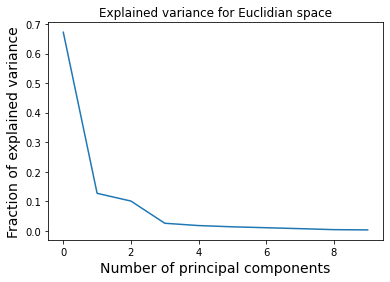

In [296]:
# TODO Take into main notebook
train_acc_avg = list()
test_acc_avg = list()

for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of principal components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.title("Explained variance for Euclidian space")

print("Average Training accuracy: " + str(np.mean(train_acc_avg)))
print("Average Test accuracy: " + str(np.mean(test_acc_avg)))

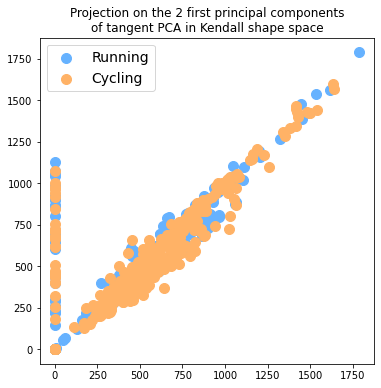

In [266]:
# TODO Take into main notebook

label_to_str = {0: "Running", 1: "Cycling"}
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}

plt.figure(figsize=(6, 6))
for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(dataset[mask, 0], dataset[mask, 1], color=col, s=100, label=label_to_str[label])
plt.legend(fontsize=14)
plt.title(
    "Projection on the 2 first principal components"
    "\nof tangent PCA in Kendall shape space"
);

In [297]:
# PCA on manifolds
def Geometric_LR(dataset,labels ):
    m_ambient = 2
    k_landmarks = 16

    preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
    matrices_metric = preshape.embedding_metric

    pose_preshape = preshape.projection(dataset)
    base_point = pose_preshape[0]
    # print(pose_preshape.shape)
    # print(preshape.belongs(pose_preshape))
    # print(gs.isclose(matrices_metric.norm(pose_preshape), 1.0))

    #Align the landmark sets in the preshape space
    pose_shape = preshape.align(point=pose_preshape, base_point=base_point)
    #print(pose_shape.shape)
    kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)

    tpca = TangentPCA(kendall_metric)
    tpca.fit(pose_shape)

    %matplotlib inline
    X = tpca.transform(pose_shape)

    #Log Reg on tangent space
    X_train_manifold, X_test_manifold, y_train_manifold, y_test_manifold = train_test_split(X,labels,train_size=0.8)

    manifold_lr = LogReg(X_train=X_train_manifold, X_test=X_test_manifold, y_train=y_train_manifold, y_test=y_test_manifold)
    manifold_lr.train_model()
    manifold_lr.test_model()

    return tpca, X


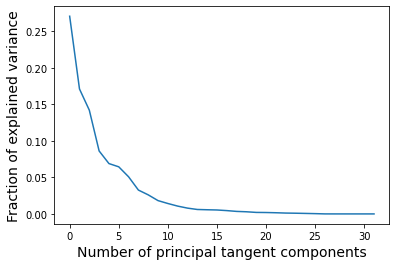

In [298]:
# TODO Take into main notebook
tpca, X = Geometric_LR(dataset,labels )
plt.figure()
plt.plot(tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14)
plt.show()

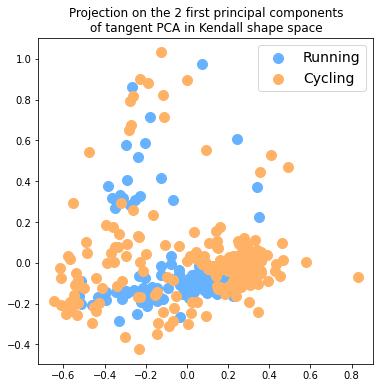

In [299]:
# TODO Take into main notebook
plt.figure(figsize=(6, 6))
for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(X[mask, 0], X[mask, 1], color=col, s=100, label=label_to_str[label])
plt.legend(fontsize=14)
plt.title(
    "Projection on the 2 first principal components"
    "\nof tangent PCA in Kendall shape space"
);

#assert feature_names[3][:-1]==feature_names[4][:-1]

AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

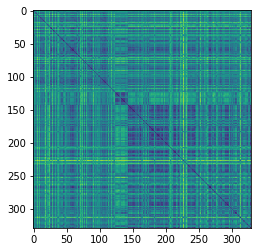

In [301]:
m_ambient = 2
k_landmarks = 16

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric
pose_preshape = preshape.projection(dataset)
base_point = pose_preshape[0]
pose_shape = preshape.align(point=pose_preshape, base_point=base_point)
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)
dist_pairwise = kendall_metric.dist_pairwise(pose_shape)
plt.figure(figsize=(4, 4))
plt.imshow(dist_pairwise);
plt.title("Distance matrix")


Logistic regression
Train accuracy: 0.749
Test accuracy: 0.7424


In [238]:
# Use distance metric to perform classification on tangent space
# 
# Not present in any notebook
# Jax Burd 
